## **Setup**

In [ ]:
# 0.1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 0.2) Project folders
BASE_DIR = "/content/drive/MyDrive/FYP"
RAW_DIR  = f"{BASE_DIR}/data/raw"
OUT_DIR  = f"{BASE_DIR}/data/processed"

# 0.3) Libraries
!pip -q install country_converter==1.2.0 pyarrow==17.0.0 openpyxl==3.1.5

import re
import pandas as pd                          # data handling
import numpy as np                           # numerical operations
import country_converter as coco             # standardize country names (“United States of America” → “USA”, “Viet Nam” → “VNM”)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
np.set_printoptions(suppress=True)

# 0.4) Reproducibility                       # ensures that random sampling, shuffling, or model initialization will give the same results every run
SEED = 42
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 28.5 MB/s eta 0:00:00


 File paths

In [ ]:
PATH_ETHNIC  = f"{RAW_DIR}/UNdata_Export_20250416_063435193.csv"
PATH_FLOW    = f"{RAW_DIR}/undesa_pd_2015_migration_flow_totals.xlsx"
PATH_STOCK   = f"{RAW_DIR}/undesa_pd_2024_ims_stock_by_sex_destination_and_origin.xlsx"

## **UNdata_Export_20250416_063435193.csv — cleaning + standardization**

In [ ]:
# 1.1) Load
ethnic = pd.read_csv(PATH_ETHNIC, encoding="utf-8", dtype=str)
print("Rows:", len(ethnic))
ethnic.head(5)

Rows: 58793


,Country or Area,Year,Area,Sex,National and/or ethnic group,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Åland Islands,2000,Total,Both Sexes,Total,Census - de jure - complete tabulation,"Final figure, complete",2009,25776,1
1,Åland Islands,2000,Total,Both Sexes,Finnish,Census - de jure - complete tabulation,"Final figure, complete",2009,5109,1
2,Åland Islands,2000,Total,Both Sexes,Swedish,Census - de jure - complete tabulation,"Final figure, complete",2009,1354,1
3,Åland Islands,2000,Total,Both Sexes,Other,Census - de jure - complete tabulation,"Final figure, complete",2009,552,1
4,Åland Islands,2000,Total,Both Sexes,Åland,Census - de jure - complete tabulation,"Final figure, complete",2009,18682,1


Helpers

In [ ]:
def _to_numeric_clean(s: pd.Series) -> pd.Series:
    """(Ethnic CSV only) Convert to numeric safely."""
    return pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("\u00A0", "", regex=False)  # non-breaking space
         .str.strip(),
        errors="coerce"
    )

def _fix_mojibake_country(name: str) -> str:
    """(Ethnic CSV only) Quick fixes for known mojibake (extend as needed)."""
    if not isinstance(name, str): return name
    fixes = {
        "Ã…land Islands": "Åland Islands",
        "CÃ´te dâ€™Ivoire": "Côte d’Ivoire",
        "CuraÃ§ao": "Curaçao",
        "RÃ©union": "Réunion",
        "SÃ£o TomÃ© and PrÃ­ncipe": "São Tomé and Príncipe"
    }
    return fixes.get(name, name)

def _strip_footnotes_block(df: pd.DataFrame) -> pd.DataFrame:
    """
    (Ethnic CSV only) Remove trailing 'Footnotes' section and any repeated header lines.
    Strategy:
      1) If a row has 'Country or Area' == 'Footnotes' (case-insensitive), drop that row and everything after.
      2) Also drop rows that look like repeated header lines inside the data.
    """
    first_col = "Country or Area"
    if first_col not in df.columns:
        return df

    # 1) Cut off everything from the first 'Footnotes' marker downwards
    foot_idx = df.index[df[first_col].astype(str).str.strip().str.lower() == "footnotes"]
    if len(foot_idx) > 0:
        df = df.loc[:foot_idx[0]-1].copy()

    # 2) Drop embedded header-like rows (where columns equal the column names string)
    header_like_mask = pd.Series(False, index=df.index)
    for col in df.columns:
        header_like_mask |= (df[col].astype(str).str.strip() == col)
    df = df.loc[~header_like_mask].copy()

    return df

Load with fallbacks

In [ ]:
# Try utf-8 first; if mojibake is severe, fall back to latin1
try:
    raw = pd.read_csv(PATH_ETHNIC, dtype=str, encoding="utf-8", low_memory=False)
except UnicodeDecodeError:
    raw = pd.read_csv(PATH_ETHNIC, dtype=str, encoding="latin1", low_memory=False)

# Ensure exact column names you provided exist
expected_cols = [
    "Country or Area","Year","Area","Sex","National and/or ethnic group",
    "Record Type","Reliability","Source Year","Value","Value Footnotes"
]
missing = [c for c in expected_cols if c not in raw.columns]
if missing:
    raise ValueError(f"Columns missing in file: {missing}\nFound: {raw.columns.tolist()}")

Remove trailing Footnotes block & accidental in-table header lines

In [ ]:
df = _strip_footnotes_block(raw)


Drop 'Value Footnotes' column (not needed for modeling)

In [ ]:
if "Value Footnotes" in df.columns:
    df = df.drop(columns=["Value Footnotes"])

Filter to Area=Total and Sex=Both Sexes

In [ ]:
df = df[
    df["Area"].astype(str).str.strip().str.lower().eq("total") &
    df["Sex"].astype(str).str.strip().str.lower().isin(["both sexes", "bothsexes", "total", "all"])
].copy()
df["Sex"] = "Both Sexes"  # normalize label casing

Drop rows missing Year or Value, then convert types

In [ ]:
df = df.dropna(subset=["Year","Value"]).copy()
df["Year"] = _to_numeric_clean(df["Year"]).astype("Int64")
df["Value"] = _to_numeric_clean(df["Value"])
df = df[np.isfinite(df["Value"])]
df = df[(df["Year"] >= 1950) & (df["Year"] <= 2100)]

Fix mojibake in country names and add ISO3

In [ ]:
df["Country or Area"] = df["Country or Area"].map(_fix_mojibake_country)
cc = coco.CountryConverter()
df["iso3"] = cc.convert(names=df["Country or Area"], to="ISO3")

In [ ]:
# Keep rows with valid ISO3 codes only
df = df[df["iso3"].notna() & (df["iso3"].str.lower() != "not found")].copy()

Build clean schema

In [ ]:
# Value here is typically a count (persons) or share; keep the Unit implicit if not present elsewhere.
ethnic_clean = (
    df.rename(columns={
        "Country or Area": "country",
        "National and/or ethnic group": "ethnic_group",
        "Source Year": "source_year",
        "Record Type": "record_type",
        "Reliability": "reliability",
        "Year": "year",
        "Value": "value",
        "Sex": "sex",
    })
    .assign(metric="ethnic_composition",
            unit="persons",                          # change to "percent" if your Value is a share
            source="UNdata_Export_20250416_063435193")
    [["iso3","country","year","ethnic_group","sex","value","metric","unit","source","source_year","record_type","reliability"]]
    .sort_values(["iso3","year","ethnic_group"])
    .reset_index(drop=True)
)

Diagnostics and Save

In [ ]:
print("Rows:", len(ethnic_clean))
print("Countries:", ethnic_clean["iso3"].nunique())
print("Years:", int(ethnic_clean["year"].min()), "→", int(ethnic_clean["year"].max()))
print("\nSample:")
display(ethnic_clean.head(8))

Rows: 7897
Countries: 109
Years: 1995 → 2023

Sample:


,iso3,country,year,ethnic_group,sex,value,metric,unit,source,source_year,record_type,reliability
0,ABW,Aruba,2000,American,Both Sexes,656,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
1,ABW,Aruba,2000,Colombian,Both Sexes,5768,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
2,ABW,Aruba,2000,Dominican,Both Sexes,2139,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
3,ABW,Aruba,2000,Dutch,Both Sexes,73440,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
4,ABW,Aruba,2000,Other,Both Sexes,5905,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
5,ABW,Aruba,2000,Portuguese,Both Sexes,82,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
6,ABW,Aruba,2000,Total,Both Sexes,90506,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"
7,ABW,Aruba,2000,Venezuelan,Both Sexes,2516,ethnic_composition,persons,UNdata_Export_20250416_063435193,2002,Census - de jure - complete tabulation,"Final figure, complete"


In [ ]:
# Save
ethnic_clean.to_csv(f"{OUT_DIR}/ethnic_composition_clean.csv", index=False)
ethnic_clean.to_parquet(f"{OUT_DIR}/ethnic_composition_clean.parquet", index=False)
print("\n✅ Saved → FYP/data/processed/ethnic_composition_clean.(csv|parquet)")


✅ Saved → FYP/data/processed/ethnic_composition_clean.(csv|parquet)


## **undesa_pd_2024_ims_stock.csv — cleaning + standardization**

Load Excel and detect sheet

In [ ]:
xls = pd.ExcelFile(PATH_STOCK, engine="openpyxl")
print("Sheets found:", xls.sheet_names)

Sheets found: ['Table of contents', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 7', 'Table 8', 'Table 9', 'Migrant notes']


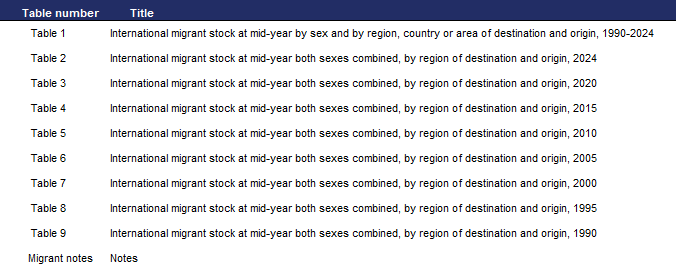

Select Table 1

In [ ]:
Sheet_to_use = "Table 1"

# Load only Table 1
t1 = pd.read_excel(xls, sheet_name=Sheet_to_use, dtype=str, skiprows=10)
print(f"\n✅ Loaded '{Sheet_to_use}")
print("Shape:", t1.shape)


# Delete ExcelFile object to free memory
del xls

t1.head(5)


✅ Loaded 'Table 1
Shape: (28030, 31)


,Index,"Region, development group, country or area of destination",Coverage,Data type,Location code of destination,"Region, development group, country or area of origin",Location code of origin,1990,1995,2000,2005,2010,2015,2020,2024,1990.1,1995.1,2000.1,2005.1,2010.1,2015.1,2020.1,2024.1,1990.2,1995.2,2000.2,2005.2,2010.2,2015.2,2020.2,2024.2
0,1,World,NaN,NaN,900,World,900,153916063,163176002,174566152,192788721,221020392,250042020,275284032,304021813,77772082,82543298,88290942,98450665,113256786,130187624,143223497,158009795,76143981,80632704,86275210,94338056,107763606,119854396,132060535,146012018
1,2,World,NaN,NaN,900,Sub-Saharan Africa,1834,14124662,15183742,14584913,16004417,18243295,22763602,27134957,30661610,7458958,8020179,7737985,8678854,9739644,12066851,14375255,16046945,6665704,7163563,6846928,7325563,8503651,10696751,12759702,14614665
2,3,World,NaN,NaN,900,Northern Africa and Western Asia,1833,14986109,17216219,18728264,21198002,25429492,32508087,37196853,40529326,8337422,9668614,10647817,12168680,14628780,18783440,21212741,22913639,6648687,7547605,8080447,9029322,10800712,13724647,15984112,17615687
3,4,World,NaN,NaN,900,Central and Southern Asia,1831,30342957,27930630,30008559,32445580,39400759,46011893,48594959,53948417,16862386,15721261,17029411,18867466,23546473,28740559,30263324,33260124,13480571,12209369,12979148,13578114,15854286,17271334,18331635,20688293
4,5,World,NaN,NaN,900,Eastern and South-Eastern Asia,1832,14465509,17262816,20822011,24315849,30053666,34562856,38223520,41409235,7069837,8373109,9761566,11238493,13840573,15768936,17926170,19677034,7395672,8889707,11060445,13077356,16213093,18793920,20297350,21732201


Helpers

In [ ]:
import re

# --- Ensure all column names are strings ---
t1.columns = t1.columns.astype(str)

# --- Identify key columns (destination and origin) safely ---
dest_col = next((c for c in t1.columns if "destination" in c.lower()), None)
orig_col = next((c for c in t1.columns if "origin" in c.lower()), None)

print("Destination column:", dest_col)
print("Origin column:", orig_col)

# --- Detect columns containing year numbers (e.g., 1990, 1995, ..., 2024) ---
year_cols = [c for c in t1.columns if re.search(r'(19|20)\d{2}', c)]

# Map column name → year number
col2year = {c: int(re.search(r'(19|20)\d{2}', c).group(0)) for c in year_cols}

# Keep first occurrence of each year (the 'both sexes' block)
seen = set()
bothsex_year_cols = []
for c in t1.columns:  # preserve left-to-right order
    if c in year_cols:
        y = col2year[c]
        if y not in seen:
            bothsex_year_cols.append(c)
            seen.add(y)

print("Both-sex year columns detected:", bothsex_year_cols)

Destination column: Region, development group, country or area of destination
Origin column: Region, development group, country or area of origin
Both-sex year columns detected: ['1990', '1995', '2000', '2005', '2010', '2015', '2020', '2024']


In [ ]:
# Rename into Destination and Origin
df = t1[[dest_col, orig_col] + bothsex_year_cols].copy()
df.rename(columns={dest_col: "destination_raw", orig_col: "origin_raw"}, inplace=True)

keep only countries/area

In [ ]:
def looks_aggregate(name: str) -> bool:
    """
    Identify if a name is a regional or development aggregate rather than a country/area.
    Returns True for things like 'World', 'Europe', 'More developed regions', etc.
    Keeps only true countries or territories.
    """
    if not isinstance(name, str) or pd.isna(name):
        return True  # not a valid name

    x = name.strip().lower()

    # 1. Exact global/development aggregates
    aggregate_exact = {
        "world", "africa", "americas", "asia", "europe", "oceania",
        "more developed regions", "less developed regions",
        "least developed countries", "land-locked developing countries (lldc)",
        "small island developing states (sids)",
        "high-and-upper-middle-income countries",
        "low-and-lower-middle-income countries",
        "high-income countries", "middle-income countries",
        "upper-middle-income countries", "lower-middle-income countries",
        "low-income countries", "no income group available",
        "developed regions", "developing regions"
    }
    if x in aggregate_exact:
        return True

    # 2. Keywords that appear only in regional or group names
    bad_keywords = [
        "region", "regions", "sub-saharan", "northern", "southern", "eastern", "western",
        "union", "americas", "caribbean", "developed", "developing",
        "income", "asia", "africa", "europe", "oceania", "ldc", "sids",
        "middle africa", "melanesia", "micronesia", "polynesia"
    ]
    if any(k in x for k in bad_keywords):
        return True

    # 3. Composite region patterns (with 'and', '/', etc.)
    if "and" in x and " " in x and len(x.split()) > 3:
        # phrases like 'central and southern asia' or 'australia and new zealand'
        return True

    # 4. Otherwise, treat as country/area
    return False


Apply improved filter to keep only true countries/areas

In [ ]:
df = df[~df["destination_raw"].apply(looks_aggregate) &
        ~df["origin_raw"].apply(looks_aggregate)].copy()

Checking

In [ ]:
print("Sample remaining destinations:", df["destination_raw"].unique()[:10])
print("Sample remaining origins:", df["origin_raw"].unique()[:10])

Sample remaining destinations: ['Australia/New Zealand' 'Burundi' 'Comoros' 'Djibouti' 'Eritrea'
 'Ethiopia' 'Kenya' 'Madagascar' 'Malawi' 'Mauritius']
Sample remaining origins: ['Australia/New Zealand' 'Burundi' 'Djibouti' 'Eritrea' 'Ethiopia' 'Kenya'
 'Madagascar' 'Malawi' 'Mauritius' 'Mozambique']


Turn the first-year block (both sexes) into rows and make year/value numeric.

In [ ]:
# Rename year columns to pure ints, then melt
rename_years = {c: col2year[c] for c in bothsex_year_cols}
df_tidy = df.rename(columns=rename_years).melt(
    id_vars=["destination_raw","origin_raw"],
    var_name="year",
    value_name="value"
)

# Numeric conversions & basic bounds
df_tidy["year"]  = pd.to_numeric(df_tidy["year"], errors="coerce").astype("Int64")
df_tidy["value"] = pd.to_numeric(
    df_tidy["value"].astype(str).str.replace(",", "", regex=False).str.strip(),
    errors="coerce"
)
df_tidy = df_tidy.dropna(subset=["year","value"])
df_tidy = df_tidy[np.isfinite(df_tidy["value"])]
df_tidy = df_tidy[(df_tidy["year"] >= 1950) & (df_tidy["year"] <= 2100)]


Add ISO3 for destination & origin

In [ ]:
import country_converter as coco
cc = coco.CountryConverter()

df_tidy["iso3_dest"] = cc.convert(names=df_tidy["destination_raw"], to="ISO3")
df_tidy["iso3_orig"] = cc.convert(names=df_tidy["origin_raw"],       to="ISO3")

# Drop unmapped rows
df_tidy.replace({"iso3_dest": {"not found": np.nan}, "iso3_orig": {"not found": np.nan}}, inplace=True)
df_tidy = df_tidy.dropna(subset=["iso3_dest","iso3_orig"])


Streaming output truncated to the last 5000 lines.


Checking

In [ ]:
sus_cols = ["iso3_dest","destination_raw","iso3_orig","origin_raw","year"]
for c in sus_cols:
    bad = df_tidy[c].apply(lambda x: isinstance(x, (list, tuple, set, dict))).sum()
    print(f"{c}: list/tuple/set/dict count = {bad}")

iso3_dest: list/tuple/set/dict count = 3272
destination_raw: list/tuple/set/dict count = 0
iso3_orig: list/tuple/set/dict count = 1672
origin_raw: list/tuple/set/dict count = 0
year: list/tuple/set/dict count = 0


In [ ]:
def to_scalar(x):
    if isinstance(x, (list, tuple, set)):
        # take first element; if it's a set, make it stable
        x = list(x)[0] if len(x) else np.nan
    elif isinstance(x, dict):
        # pick a deterministic representation (e.g., join keys)
        x = ";".join(sorted(map(str, x.keys())))
    return x

for c in ["iso3_dest","destination_raw","iso3_orig","origin_raw"]:
    df_tidy[c] = df_tidy[c].apply(to_scalar)

# Make sure everything is a clean scalar type
df_tidy["destination_raw"] = df_tidy["destination_raw"].astype(str).str.strip()
df_tidy["origin_raw"]       = df_tidy["origin_raw"].astype(str).str.strip()
df_tidy["iso3_dest"]        = df_tidy["iso3_dest"].astype(str).str.strip()
df_tidy["iso3_orig"]        = df_tidy["iso3_orig"].astype(str).str.strip()
df_tidy["year"]             = pd.to_numeric(df_tidy["year"], errors="coerce").astype("Int64")


Un-duplicate

In [ ]:
# Remove origin==destination if you don’t want same-country stock
df_tidy = df_tidy[df_tidy["iso3_dest"] != df_tidy["iso3_orig"]].copy()

# If duplicates exist for same (dest, orig, year), sum them
df_tidy = (df_tidy
           .groupby(["iso3_dest","destination_raw","iso3_orig","origin_raw","year"], as_index=False)
           .agg(value=("value","sum")))


In [ ]:
ims_clean = (df_tidy
             .assign(metric="migrant_stock", sex="Both sexes", unit="persons",
                     source="UNDESA_2024_IMS_Table1_bothsex")
             [["iso3_dest","destination_raw","iso3_orig","origin_raw","year",
               "sex","value","metric","unit","source"]]
             .sort_values(["iso3_dest","iso3_orig","year"])
             .reset_index(drop=True))

print("Rows:", len(ims_clean),
      "| Destinations:", ims_clean["iso3_dest"].nunique(),
      "| Origins:", ims_clean["iso3_orig"].nunique(),
      "| Years:", int(ims_clean["year"].min()), "→", int(ims_clean["year"].max()))


Rows: 72983 | Destinations: 215 | Origins: 216 | Years: 1990 → 2024


In [ ]:
# Save (adjust paths to your project if you like)
ims_clean.to_csv(f"{OUT_DIR}/ims_stock_table1_bothsex_countries.csv", index=False)
ims_clean.to_parquet(f"{OUT_DIR}/ims_stock_table1_bothsex_countries.parquet", index=False)